In [2]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath, ufloat_fromstr

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [3]:
coinc_counts = np.loadtxt('../data/gamma2_run2.TKA', unpack=True)
all_counts = np.loadtxt('../data/co57_G20.TKA', unpack=True)
bins = np.arange(0, len(all_counts))
# idx = np.nonzero(coinc_counts)
idx = slice(111, 170)
coinc_counts = coinc_counts[idx]
all_counts = all_counts[idx]
bins = bins[idx]

In [4]:
normalized_all = all_counts / np.sum(all_counts)
normalized_coinc = coinc_counts / np.sum(coinc_counts) * 0.88

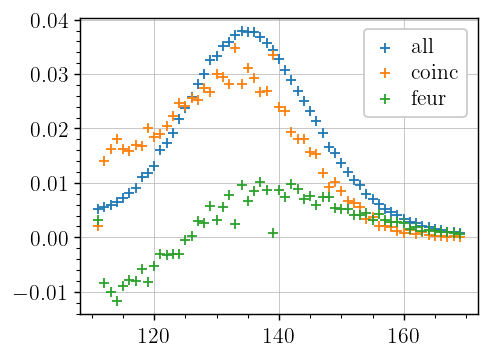

In [5]:
plt.scatter(bins, normalized_all, label='all')
plt.scatter(bins, normalized_coinc, label='coinc')
plt.scatter(bins, normalized_all - normalized_coinc, label='feur')
plt.legend()
# plt.yscale('log')
# plt.xlim(0, 300)

In [6]:
with open('../data/energy_calibration_coefs.csv', 'r') as f:
    s = f.read()
    a, b = s.split(',')
    a = ufloat_fromstr(a)
    b = ufloat_fromstr(b)
fitfunc = np.poly1d([a.n, b.n])

In [7]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))

Energy gamma3 128+/-24
Energy gamma2 119+/-23


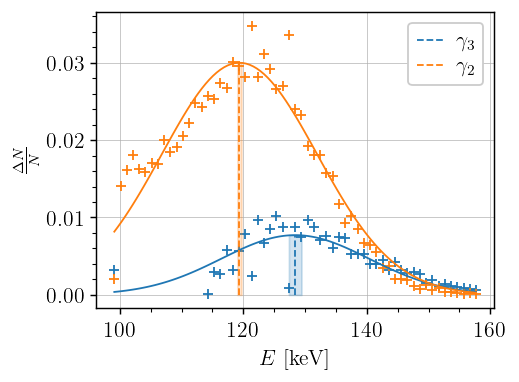

In [50]:
gamma3 = normalized_all - normalized_coinc

idx = gamma3 > 0
gamma3_filtered = gamma3[idx]
bins_filtered = bins[idx]

coefs_gamma3, pcov_gamma3 = sc.optimize.curve_fit(
    gauss, bins_filtered, gamma3_filtered,
    p0=(1, 90, 10),
    bounds=((0, 50, 1), (np.inf, 140, np.inf))
)
coefs_err_gamma3 = unp.uarray(coefs_gamma3, np.sqrt(np.diag(pcov_gamma3)))
coefs_gamma2, pcov_gamma2 = sc.optimize.curve_fit(
    gauss, bins, normalized_coinc,
    p0=(1, 90, 10),
    bounds=((0, 50, 1), (np.inf, 140, np.inf))
)
coefs_err_gamma2 = unp.uarray(coefs_gamma2, np.sqrt(np.diag(pcov_gamma2)))

print("Energy gamma3", energy_gamma3 := a*coefs_err_gamma3[1] + b)
print("Energy gamma2", energy_gamma2 := a*coefs_err_gamma2[1] + b)

plt.scatter(fitfunc(bins_filtered), gamma3_filtered)
plt.scatter(fitfunc(bins), normalized_coinc)
x = np.linspace(bins.min(), bins.max(), 100)
plt.plot(fitfunc(x), gauss(x, *coefs_gamma3))
plt.plot(fitfunc(x), gauss(x, *coefs_gamma2))

# plt.axvline(fitfunc(coefs_gamma3[1]))
x = np.linspace(coefs_err_gamma3[1].n - coefs_err_gamma3[1].s, coefs_err_gamma3[1].n + coefs_err_gamma3[1].s)
plt.fill_between(fitfunc(x), 0, gauss(x, *coefs_gamma3), color='C0', alpha=0.2)
plt.vlines(fitfunc(coefs_gamma3[1]), 0, gauss(coefs_gamma3[1], *coefs_gamma3), color='C0', ls='--', label=r'$\gamma_3$')

x = np.linspace(coefs_err_gamma2[1].n - coefs_err_gamma2[1].s, coefs_err_gamma2[1].n + coefs_err_gamma2[1].s)
plt.fill_between(fitfunc(x), 0, gauss(x, *coefs_gamma2), color='C1', alpha=0.2, interpolate=True)
plt.vlines(fitfunc(coefs_gamma2[1]), 0, gauss(coefs_gamma2[1], *coefs_gamma2), color='C1', ls='--', label=r'$\gamma_2$')

plt.xlabel(r'$E$ [keV]')
plt.ylabel(r'$\frac{\Delta N}{N}$')
plt.legend()
plt.savefig('../figures/co57_gamma2_gamma3.pdf')